In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

import pandas as pd
import torch as th
import numpy as np

In [9]:
batch_size = 128
hist_win = 7
pred_win = 1

In [10]:
df = pd.read_csv('~/data/stock/kaggle/full_history/GOOG.csv')
df.head()

,date,volume,open,high,low,close,adjclose
0,2020-07-02,1859100,1446.939941,1482.949951,1446.420044,1464.699951,1464.699951
1,2020-07-01,1775200,1411.099976,1443.000000,1409.819946,1438.040039,1438.040039
2,2020-06-30,2042400,1390.439941,1418.650024,1383.959961,1413.609985,1413.609985
3,2020-06-29,1810200,1358.180054,1395.599976,1347.010010,1394.969971,1394.969971
4,2020-06-26,4267700,1431.390015,1433.449951,1351.989990,1359.900024,1359.900024


In [11]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Caveats
#   - looks at only 1 column
class StockSeqDataset(Dataset):
    def __init__(self, df, column='adjclose', hist_win=hist_win, pred_win=pred_win):
        self.df = df
        self.col = column
        self.hist_win = hist_win
        self.pred_win = pred_win
    
    def __getitem__(self, index):
        assert 0 <= index < len(self)
        x_end = index + self.hist_win
        x = df.iloc[index:x_end][self.col]
        y = df.iloc[x_end:x_end+self.pred_win][self.col]
        return (th.from_numpy(np.array(x, dtype=np.float32)),
                th.from_numpy(np.array(y, dtype=np.float32)))
    
    def __len__(self):
        return len(self.df) - self.hist_win - self.pred_win + 1

ds = StockSeqDataset(df)

dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)

In [12]:
ds[len(ds) - 1]

(tensor([50.8145, 52.8768, 53.7535, 52.8021, 52.2392, 54.4957, 53.9528]),
 tensor([49.9827]))

In [13]:
for x, y in dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 7])
torch.Size([128, 1])


In [14]:
model = th.nn.Sequential(
    th.nn.Linear(hist_win, pred_win),
    #th.nn.ReLU(),
    #th.nn.Linear(100, pred_win),
)

loss_fn = th.nn.MSELoss()

learning_rate = 0.005
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.5))
lr_schedule = th.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

for epoch in range(20):
    loss_avg = 0
    for x, y in dl:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
        #print(loss.item())
    lr_schedule.step()
    print(f'{lr_schedule.get_lr()[0]:.5f} {loss_avg / len(dl)}')

/home/z/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:425: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


0.00405 780802.9736328125
0.00365 66185.73609280586
0.00328 223.3064558506012
0.00295 221.34980511665344
0.00266 207.60730147361755
0.00239 208.96934485435486
0.00215 205.91821122169495
0.00194 206.91457450389862
0.00174 207.60276556015015
0.00157 196.41852164268494
0.00141 187.75421285629272
0.00127 197.85498690605164
0.00114 188.61241006851196
0.00103 195.35809755325317
0.00093 190.03267550468445
0.00083 182.6825258731842
0.00075 180.61653923988342
0.00068 180.5643711090088
0.00061 180.78356957435608
0.00055 181.1865792274475


In [15]:
lr_schedule.get_lr()

[0.0005470949456575623]

In [16]:
y.t()

tensor([[1163.6899,  998.6800, 1202.3101, 1105.5200,  255.4176,  295.0939,
          626.9100,  578.6115,  957.0900,  607.8068,  218.2220, 1458.6300,
          109.4796,  737.7800,  537.6938,  240.4487, 1243.6400,  302.6506,
          194.4860, 1372.5601,  183.3627]])

In [17]:
model(x).t()

tensor([[1120.2329, 1018.1248, 1221.7130, 1134.0724,  255.2432,  289.6360,
          643.9533,  575.0045,  941.7716,  605.8735,  226.4985, 1457.9528,
          110.5516,  738.0855,  530.7165,  237.3310, 1253.4470,  306.8478,
          195.9410, 1385.5980,  177.5125]], grad_fn=<TBackward>)

In [22]:
def validate(model, ticker):
    df = pd.read_csv(f'~/data/stock/kaggle/full_history/{ticker}.csv')
    ds = StockSeqDataset(df)
    dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False)
    loss_avg = 0
    actual = []
    predicted = []
    for x, y in dl:
        actual.append(y.detach().cpu().numpy())
        optimizer.zero_grad()
        y_pred = model(x)
        predicted.append(y_pred.detach().cpu().numpy())
        loss = loss_fn(y_pred, y)
        loss_avg += loss.item()
    actual = np.concatenate(actual)
    predicted = np.concatenate(predicted)
    print(predicted.shape)
    loss_avg /= len(dl)
    print(f'Avg loss: {loss_avg}')
    return actual, predicted, loss_avg

class MeanModel(th.nn.Module):
    def forward(self, x):
        return x.mean(dim=-1)

def plot(predicted, actual):
    plt.figure()
    plt.plot(np.squeeze(predicted)[::-1])
    plt.plot(np.squeeze(actual)[::-1])

In [23]:
list(model.parameters())

[Parameter containing:
 tensor([[0.1630, 0.1522, 0.0049, 0.0067, 0.0153, 0.1636, 0.4931]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0207], requires_grad=True)]

In [24]:
actual, pred, loss_avg = validate(model, 'FB')

(2037, 1)
Avg loss: 305.5759310722351


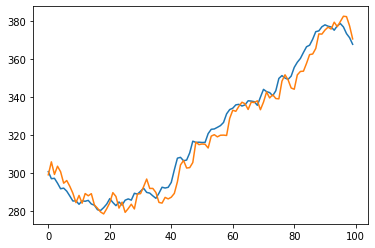

In [25]:
plot(pred[-100:], actual[-100:])

In [26]:
# Baseline
actual, pred, loss_avg = validate(MeanModel(), 'FB')

/home/z/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


(2037,)
Avg loss: 5583.202747344971


/home/z/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([117, 1])) that is different to the input size (torch.Size([117])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [27]:
MeanModel()(th.Tensor([[1, 2, 3], [2, 4, 6]]))

tensor([2., 4.])